# Technical Analysis and Model Building for stock/crypto

## Table of content



1. Pre-requsite
2. Model training with initial setting
3. RandomizedSearchCv to search for best hyper parameter
4. Model training with tuned setting
5. Model error comparison between initial setting and tuned hyper-parameter model
6. Tuned-model feature importance visualization

### Part 1:Data processing and manipulation

__Pre-requisite : Install tensorflow and plotly library__

In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly as py
py.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import datetime

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

Additional library installation for stock price pulling (This could be used for different stock country stock price which can be found in yahoo finance)

In [4]:
!pip install pandas_datareader

  Using cached pandas_datareader-0.9.0-py3-none-any.whl (107 kB)


In [5]:
!pip install fix-yahoo-finance

  Using cached fix_yahoo_finance-0.1.37-py3-none-any.whl
  Using cached multitasking-0.0.9-py3-none-any.whl
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=a7821ed4f52e9d21fe1746ac9556e302e7bf950e9625b55be5e3741c4b545c29
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\26\af\8b\fac1b47dffef567f945641cdc9b67bb25fae5725d462a8cf81
Successfully built yfinance


__Sample of pulling stock price from yahoo finance (Intel share price)__

In [9]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf

stock_name = 'INTC'
data_INTEL= yf.pdr_override(stock_name,start='2019-1-1')

[*********************100%***********************]  1 of 1 completed


In [10]:
data_INTEL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,47.090000,47.480000,46.549999,46.930000,44.407246,20490400
2019-01-02,45.959999,47.470001,45.770000,47.080002,44.549191,18774600
2019-01-03,46.150002,46.279999,44.389999,44.490002,42.098412,32267300
2019-01-04,45.840000,47.570000,45.540001,47.220001,44.681660,35447300
2019-01-07,47.099998,48.000000,46.750000,47.439999,44.889828,22736800
...,...,...,...,...,...,...
2021-04-23,59.160000,60.000000,57.900002,59.240002,59.240002,77479500
2021-04-26,59.099998,59.520000,58.459999,58.759998,58.759998,39645900
2021-04-27,58.560001,58.630001,57.770000,57.970001,57.970001,38167700


'''
To analyse Intel share price further , we can look at more than just pricing sense (as share price is not a good "label" to in any AI/ML model)

TL;DR;

Market forecasts are particularly tricky. No one can see the future – the world is inherently uncertain and surprising things will happen. Even if you know what’s going to happen, however, you might not know how markets will respond. - Irish Times

https://www.irishtimes.com/business/personal-finance/why-do-we-bother-with-stock-market-forecasts-1.3747774
'''

# Bonus section : Crypto Currencies data pulling

In [7]:
!pip install cryptocmd

In [15]:
from cryptocmd import CmcScraper

# initialise scraper without time interval
scraper = CmcScraper("ETH")

# get raw data as list of list
headers, data = scraper.get_data()

# get data in a json format
xrp_json_data = scraper.get_data("json")

# export the data as csv file, you can also pass optional `name` parameter
scraper.export("csv", name="eth_all_time")

# Pandas dataFrame for the same data
df_eth = scraper.get_dataframe()

In [14]:
from cryptocmd import CmcScraper

# initialise scraper without time interval
scraper = CmcScraper("BTC")

# get raw data as list of list
headers, data = scraper.get_data()

# get data in a json format
xrp_json_data = scraper.get_data("json")

# export the data as csv file, you can also pass optional `name` parameter
scraper.export("csv", name="btc_all_time")

# Pandas dataFrame for the same data
df_btc = scraper.get_dataframe()

In [26]:
from cryptocmd import CmcScraper

# initialise scraper without time interval
scraper = CmcScraper("DOGE")

# get raw data as list of list
headers, data = scraper.get_data()

# get data in a json format
xrp_json_data = scraper.get_data("json")

# export the data as csv file, you can also pass optional `name` parameter
scraper.export("csv", name="doge_all_time")

# Pandas dataFrame for the same data
df_doge = scraper.get_dataframe()

In [17]:
df_btc

,Date,Open,High,Low,Close,Volume,Market Cap
0,2021-04-30,53568.663584,57900.719988,53129.600877,57750.177346,5.239593e+10,1.079670e+12
1,2021-04-29,54858.091492,55115.844154,52418.028445,53555.108491,4.608893e+10,1.001194e+12
2,2021-04-28,55036.637419,56227.205648,53887.917817,54824.704895,4.800057e+10,1.024888e+12
3,2021-04-27,54030.303718,55416.964058,53319.186654,55033.118013,4.944822e+10,1.028733e+12
4,2021-04-26,49077.792363,54288.002155,48852.796843,54021.754787,5.828404e+10,1.009780e+12
...,...,...,...,...,...,...,...
2920,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
2921,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
2922,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
2923,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09


In [27]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_btc['Date'], y=df_btc['Close'], name='BTC Close'))
fig.add_trace(go.Scatter(x=df_doge['Date'], y=df_doge['Close'], name='DOGE Close'),secondary_y=True)

fig.update_layout(showlegend=True, title='Bitcoin and Ethereum Close Price')
fig.show()

In [3]:
!pip install python-binance

In [4]:
!pip install tqdm

In [5]:
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = 'uaaHCahiHS1cImSFURe763flVHhgQPPQRV6kdjIzehjvBzMrYA8RNPAwcHo52jAv'    #Enter your own API-key here
binance_api_secret = 'rNWrITKX1Bycu8D6GMlpnCl1PCNskTSPOZbqQEZxOh992s7JvYcFqdm0RbS11ZcG' #Enter your own API-secret here


In [6]:
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


In [43]:
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = 'uaaHCahiHS1cImSFURe763flVHhgQPPQRV6kdjIzehjvBzMrYA8RNPAwcHo52jAv'    #Enter your own API-key here
binance_api_secret = 'rNWrITKX1Bycu8D6GMlpnCl1PCNskTSPOZbqQEZxOh992s7JvYcFqdm0RbS11ZcG' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm_notebook(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [44]:
binance_symbols = ["ETHBUSD"]
for symbol in binance_symbols:
    get_all_binance(symbol, '1h', save = True)

All caught up..!


In [12]:
timestamp = Client._get_earliest_valid_timestamp('ETHUSDT', '1d')
bars = Client.get_historical_klines('ETHUSDT', '1h', timestamp, limit=1000)

TypeError: _get_earliest_valid_timestamp() missing 1 required positional argument: 'interval'

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=vis1_df.index, y=vis1_df['Adj Close'], name='Adj Close'))
fig.update_layout(showlegend=True, title='Tool utilization percentage')
fig.show()

In [15]:
!pip install seaborn

In [21]:
!pip install tabulate

  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)


In [112]:
!pip install mplfinance

In [16]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [148]:
# binance_symbols = ["DOGEBUSD"]
doge_data = get_all_binance("ETHBUSD", '1d', save = True)[-150:]

All caught up..!


In [186]:
def trending(df):
    if (df['close'] - df['open']) > 0:
        return 'green'
    else:
        return 'red'

In [187]:

doge_data['tag'] = doge_data.apply(trending,axis=1)

C:\Users\User\anaconda3\envs\gputensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [188]:
doge_data

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,tag
timestamp,,,,,,,,,,,,
2020-12-09,554.67,577.88,530.26,573.4,303439.6757,1607558399999,169067728.757949,362703,157123.28612,87536280.597826,0,green
2020-12-10,573.39,575.64,548.08,558.92,206792.56665,1607644799999,116071329.816511,269599,100750.12757,56543839.71332,0,red
2020-12-11,558.9,560.57,535.14,544.38,246208.704,1607731199999,134332596.538422,362750,119863.75085,65406912.660672,0,red
2020-12-12,544.41,573.97,543.08,568.33,161082.18667,1607817599999,90156018.021296,240979,83193.32206,46562437.306129,0,green
2020-12-13,568.33,595.0,563.56,590.67,207854.03031,1607903999999,121189329.703286,267181,107594.05717,62761410.738449,0,green
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2322.82,2543.97,2305.91,2534.5,378394.19446,1619481599999,934554674.280437,737559,191411.07713,472688467.207486,0,green
2021-04-27,2534.46,2684.5,2483.43,2668.5,248921.01968,1619567999999,643616185.52004,519834,127215.22995,329079733.199465,0,green
2021-04-28,2668.5,2763.99,2562.69,2750.0,316980.04258,1619654399999,849788370.49526,716265,161705.43571,433513630.71998,0,green


In [189]:
doge_data = doge_data.reset_index()
doge_data['timestamp'] =  pd.to_datetime(doge_data['timestamp'])
doge_data = doge_data.set_index('timestamp')

In [190]:
doge_data = doge_data[doge_data.index < '2021-05-01']

In [191]:
# Template code for use on stock visualization
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import matplotlib.dates as mpl_dates


plt.style.use('ggplot')

def plot_chart(df,stock_name):
    # Extracting Data for plotting
    data = df
    ohlc = data.loc[:, ['open', 'high', 'low', 'close','volume']]
    ohlc = ohlc.astype({'open': 'float64', 'high': 'float64','low':'float64','close':'float64','volume':'float64'})
#     fig.suptitle('Daily Candlestick Chart of NIFTY50')

    mpf.plot(ohlc,type='candle',style='charles',mav=(20,50,100),volume=True)

    # Setting labels & titles
    # ax.set_xlabel('Date')
    # ax.set_ylabel('Price')

    # # Formatting Date
    # date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    # ax.xaxis.set_major_formatter(date_format)
    # fig.autofmt_xdate()
    plt.show()
    return

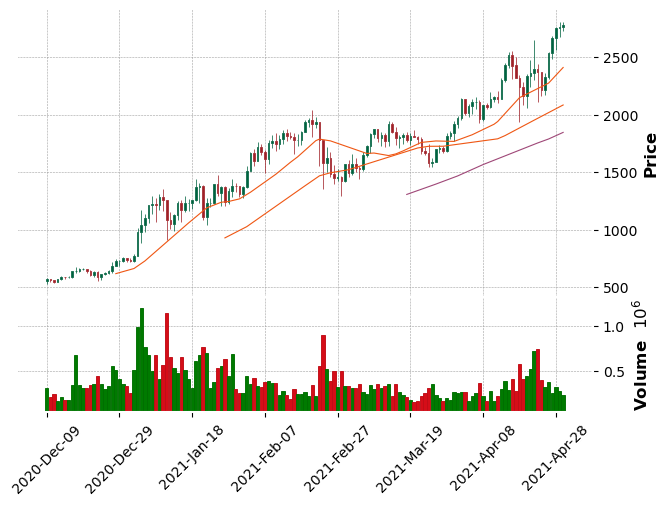

In [192]:
plot_chart(doge_data,'Ethereum')


In [193]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
            go.Candlestick(
                x=doge_data.index,
                low=doge_data.low,
                high=doge_data.high,
                close=doge_data.close,
                open=doge_data.open,
                increasing_line_color='green',
                decreasing_line_color='red'
            )
)
fig.add_trace(go.Bar(x=doge_data.index, y=doge_data['volume'],marker={'color': doge_data['tag']}),secondary_y=True)


fig.update_layout(
    title = 'Ethereum Price',
    yaxis_title = 'Ethereum Price USD ($)',
    xaxis_title = 'Date'
)
fig.show()

In [88]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=doge_data.index, y=doge_data['close'], name='Close'))
fig.update_layout(showlegend=True, title='ETH Price')
fig.show()

In [82]:
r = requests.get("https://api.binance.com/api/v3/depth",
                 params=dict(symbol="ETHBUSD"))
results = r.json()

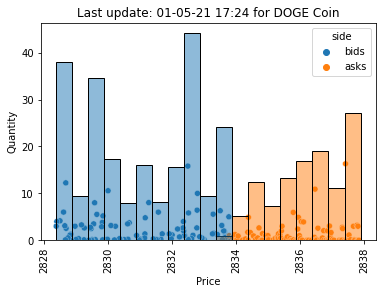

In [83]:
binwidth = 0.5
frames = {side: pd.DataFrame(data=results[side], columns=["price", "quantity"],
                             dtype=float)
          for side in ["bids", "asks"]}
frames_list = [frames[side].assign(side=side) for side in frames]
data = pd.concat(frames_list, axis="index", 
                 ignore_index=True, sort=True)
price_summary = data.groupby("side").price.describe()
fig, ax = plt.subplots()

ax.set_title(f"Last update: {datetime.now().strftime('%d-%m-%y %H:%M')} for DOGE Coin")
sns.histplot(x="price", weights="quantity", hue="side", binwidth=binwidth, data=data, ax=ax)
sns.scatterplot(x="price", y="quantity", hue="side", data=data, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quantity")
plt.xticks(rotation=90)
plt.show()

In [72]:
train, test = vis1_df.loc[vis1_df.index <= '2020-10-01'], vis1_df.loc[vis1_df.index > '2020-10-01']
train.shape, test.shape

((443, 6), (144, 6))

In [73]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Adj Close']])

train['Adj Close'] = scaler.transform(train[['Adj Close']])
test['Adj Close'] = scaler.transform(test[['Adj Close']])

C:\Users\User\anaconda3\envs\gputensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\anaconda3\envs\gputensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [74]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Adj Close']], train['Adj Close'])
X_test, y_test = create_sequences(test[['Adj Close']], test['Adj Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (413, 30, 1)
Testing shape: (114, 30, 1)


In [75]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 30, 64)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

In [76]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/100
24/24 [==============================] - 1s 33ms/step - loss: 0.4776 - val_loss: 0.2478
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.3250 - val_loss: 0.1826
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2672 - val_loss: 0.1491
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2622 - val_loss: 0.2276
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2544 - val_loss: 0.1440
Epoch 6/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2629 - val_loss: 0.2468
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2929 - val_loss: 0.1283
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2449 - val_loss: 0.1522
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2594 - val_loss: 0.1287
Epoch 10/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2296 - val_loss: 0.1236

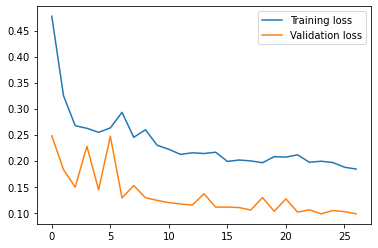

In [77]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [78]:
model.evaluate(X_test, y_test)


4/4 [==============================] - 0s 3ms/step - loss: 0.2111


0.21107375621795654

Reconstruction error threshold: 2.276636661638086


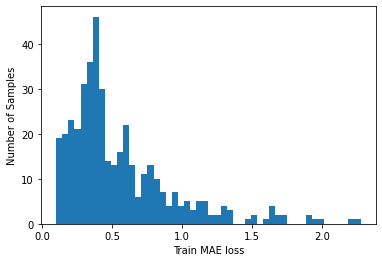

In [79]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

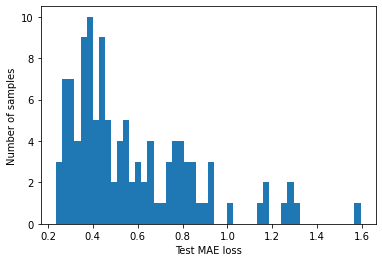

In [80]:

X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [81]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = 1.0
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Adj Close'] = test[TIME_STEPS:]['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [82]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(9, 9)

In [83]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=test_score_df.index, y=scaler.inverse_transform(test_score_df['Adj Close']), name='Adj Close '))
fig.add_trace(go.Scatter(x=anomalies.index, y=scaler.inverse_transform(anomalies['Adj Close']), mode='markers', name='Anomaly'))
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['threshold'], name='Threshold'),secondary_y=True)
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['loss'], name='loss'),secondary_y=True)

fig.update_layout(showlegend=True, title='Detected anomalies on {}'.format(tool_name))
py.offline.plot(fig, filename='myplot.html')


'myplot.html'

# Sample code for simple visualization of periodic signal using Keras
Reference link : https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [45]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [46]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

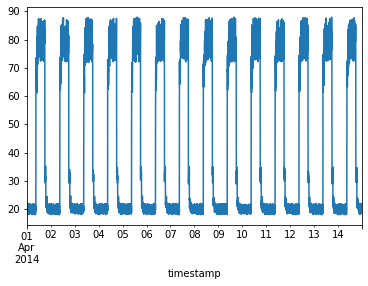

In [48]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

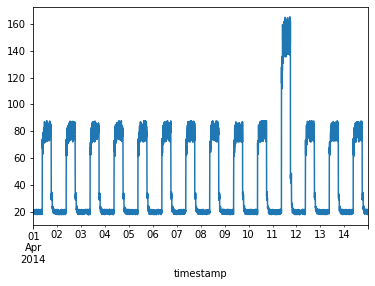

In [49]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [50]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [51]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


In [60]:
x_train 

array([[[-0.85882857],
        [-0.72899302],
        [-0.84814772],
        ...,
        [-0.86453747],
        [-0.81250829],
        [-0.79671155]],

       [[-0.72899302],
        [-0.84814772],
        [-0.72958579],
        ...,
        [-0.81250829],
        [-0.79671155],
        [-0.78767946]],

       [[-0.84814772],
        [-0.72958579],
        [-0.731173  ],
        ...,
        [-0.79671155],
        [-0.78767946],
        [-0.73706287]],

       ...,

       [[-0.82404796],
        [-0.8226548 ],
        [-0.86660975],
        ...,
        [-0.8017893 ],
        [-0.79164661],
        [-0.78025492]],

       [[-0.8226548 ],
        [-0.86660975],
        [-0.82181363],
        ...,
        [-0.79164661],
        [-0.78025492],
        [-0.83364049]],

       [[-0.86660975],
        [-0.82181363],
        [-0.75595835],
        ...,
        [-0.78025492],
        [-0.83364049],
        [-0.73510213]]])

Model building on Keras

In [52]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_9 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)           

In [53]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 29ms/step - loss: 0.4626 - val_loss: 0.1132
Epoch 2/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0752 - val_loss: 0.0435
Epoch 3/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0549 - val_loss: 0.0386
Epoch 4/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0470 - val_loss: 0.0328
Epoch 5/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0406 - val_loss: 0.0291
Epoch 6/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0356 - val_loss: 0.0268
Epoch 7/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0320 - val_loss: 0.0225
Epoch 8/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0290 - val_loss: 0.0230
Epoch 9/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0267 - val_loss: 0.0226
Epoch 10/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0250 - val_loss: 0.0236
Epoch 11/

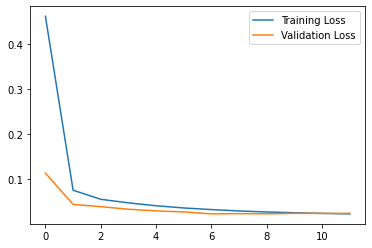

In [54]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Detecting Anomalies

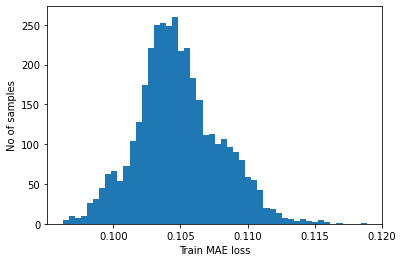

Reconstruction error threshold:  0.11887500069574994


In [55]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

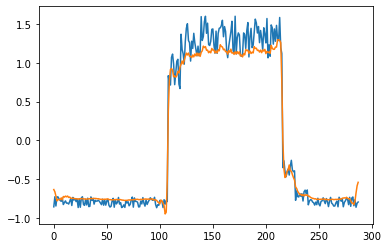

In [56]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

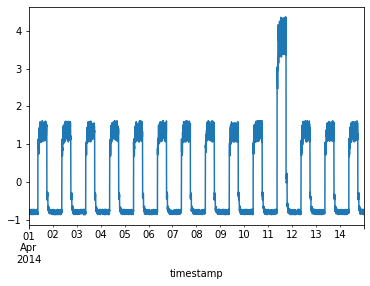

Test input shape:  (3744, 288, 1)


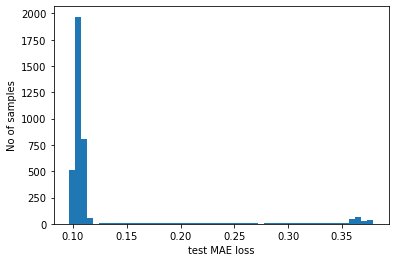

Number of anomaly samples:  396
Indices of anomaly samples:  (array([1654, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831,
       2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2

In [57]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [58]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

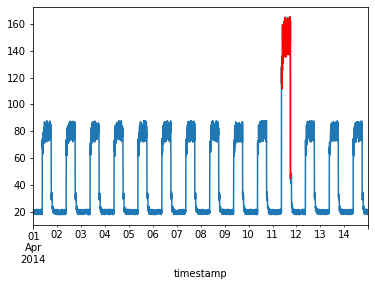

In [59]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()